# Visualizing Distribution of Bus Stops in Vancouver

### Started and Completed on May 13th, 2020

I use two separate APIs in this project, one from Translink, which iterates over 400 coordinate pairs in metro vancouver and pulls in a list of all the bus stops. I then use a second API from mapquest to get a map of metro 
vancouver, which I can then plot all of my coordinate points on. Note that the coordinate pairs have to be converted
into X and Y coordinates in order to plot on the image of vancouver. Due to the nature of the mapquest API, this 
ended up being nontrivial. 

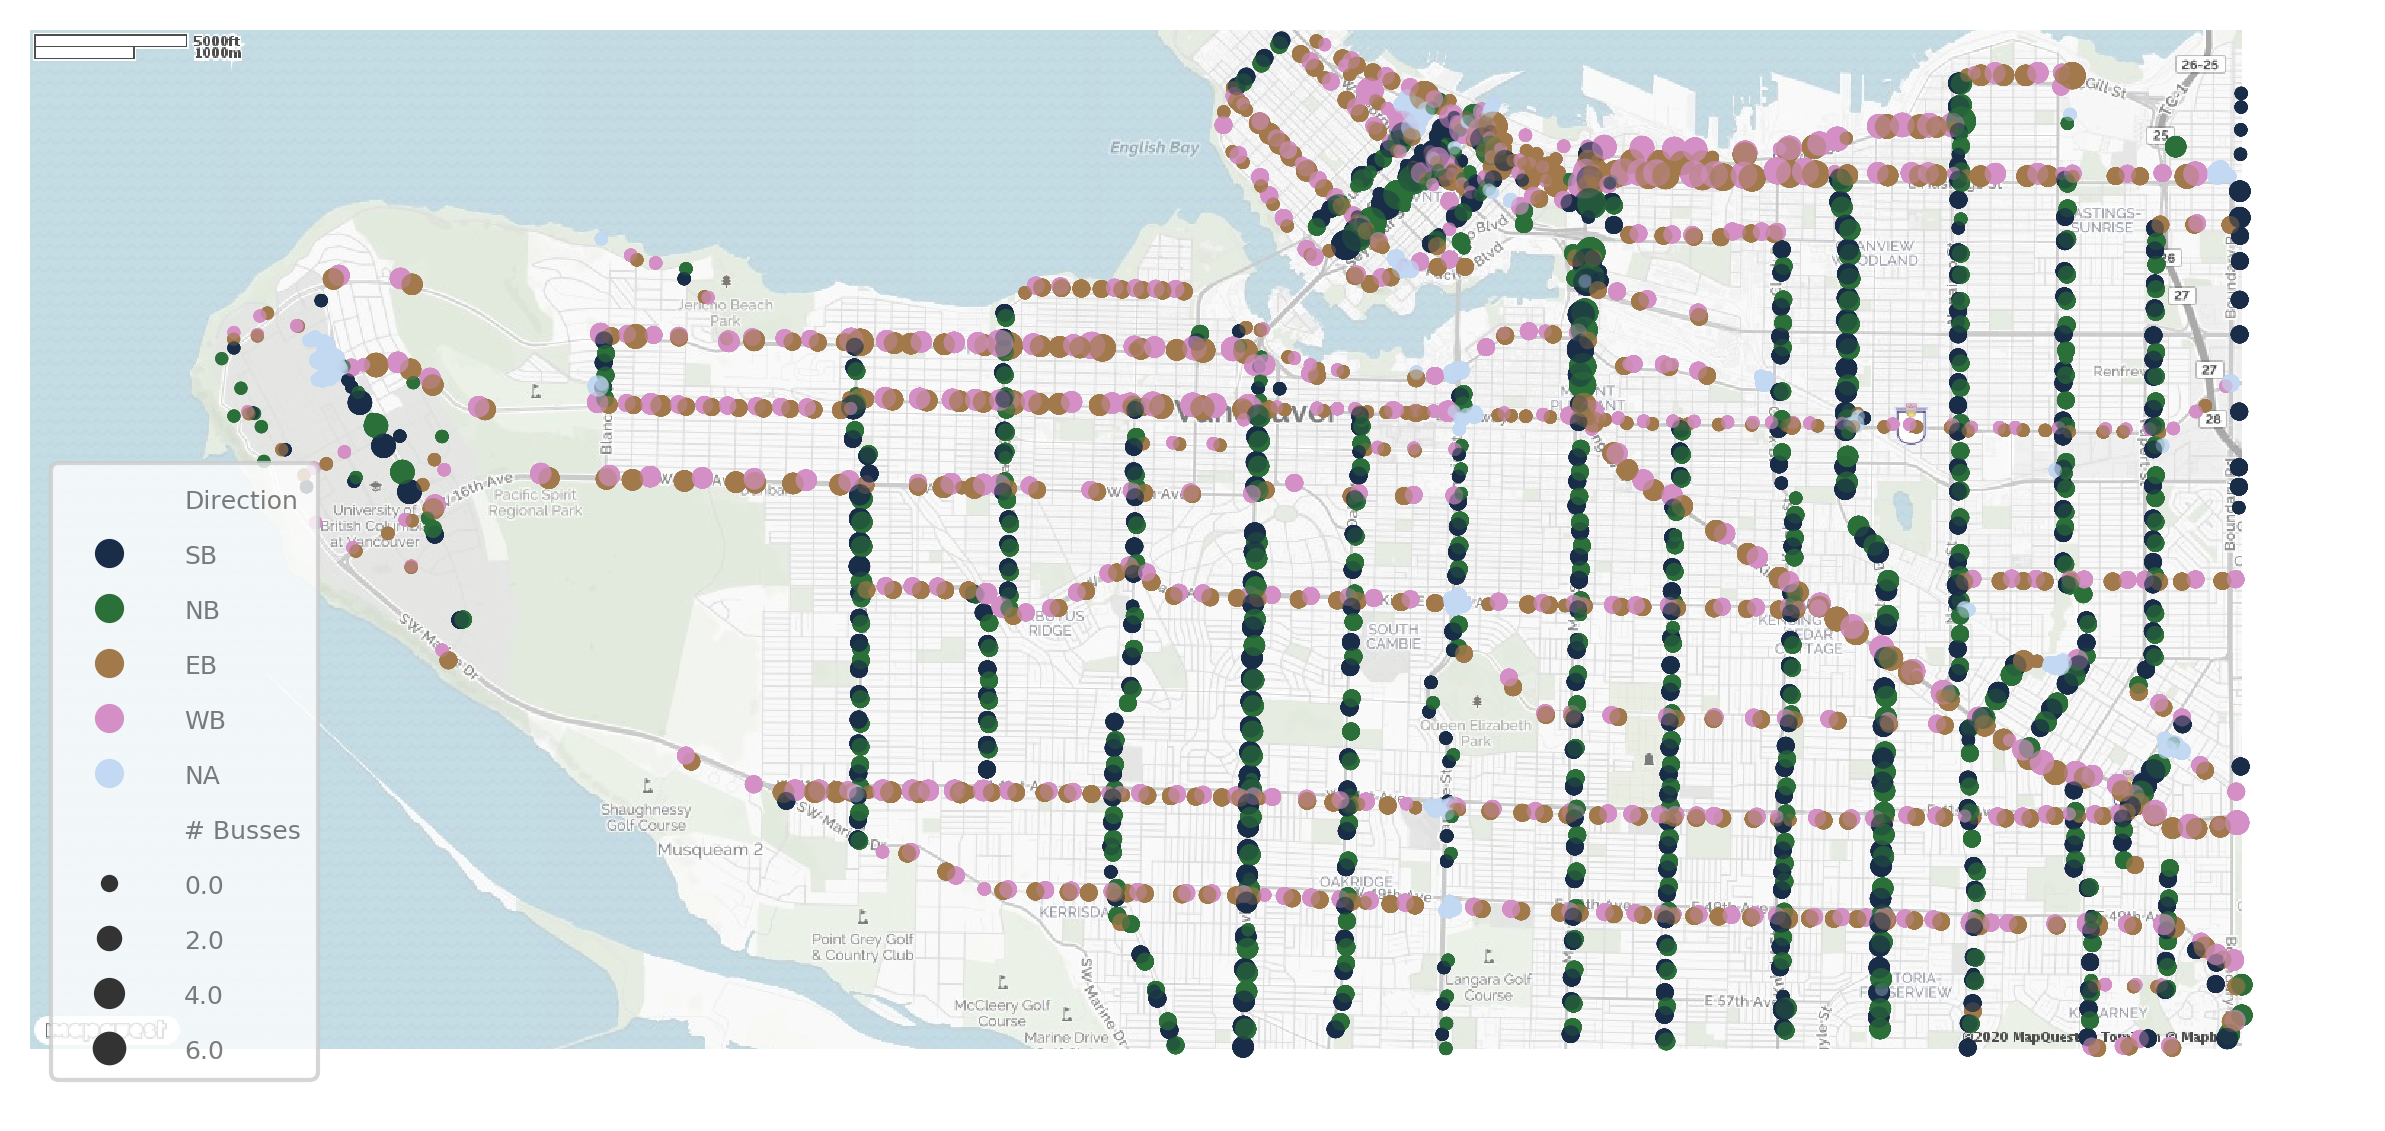

In [2]:
from TranslinkAccess import TranslinkAPI

TAPI = TranslinkAPI() 